In [6]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image
from sklearn.decomposition import PCA
import glob
import string

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Load files

In [23]:
files_dict={}

for fl in glob.glob("../20160223_BamData/NoA/*"):
    a= (fl.split('/')[-1]).split('_cut')[0]
    if a:
        files_dict[a]=pd.read_csv(fl, sep="\t", header=None)[3]
NoA=pd.DataFrame(files_dict)
     
files_dict={}
for fl in glob.glob("../20160223_BamData/AdRp/*"):
    a= (fl.split('/')[-1]).split('_cut')[0]
    if a:
        files_dict[a]=pd.read_csv(fl, sep="\t", header=None)[3]   
AdRp=pd.DataFrame(files_dict)

Check that columns are in same order

In [24]:
#Remove NoA and AdRp label from columns
AdRp.columns=[ele[:-5] for ele in AdRp.columns]
NoA.columns=[ele[:-4] for ele in NoA.columns]


In [27]:
sum(AdRp.columns.values == NoA.columns.values) == len(AdRp.columns)

True

# Correlate dataframes

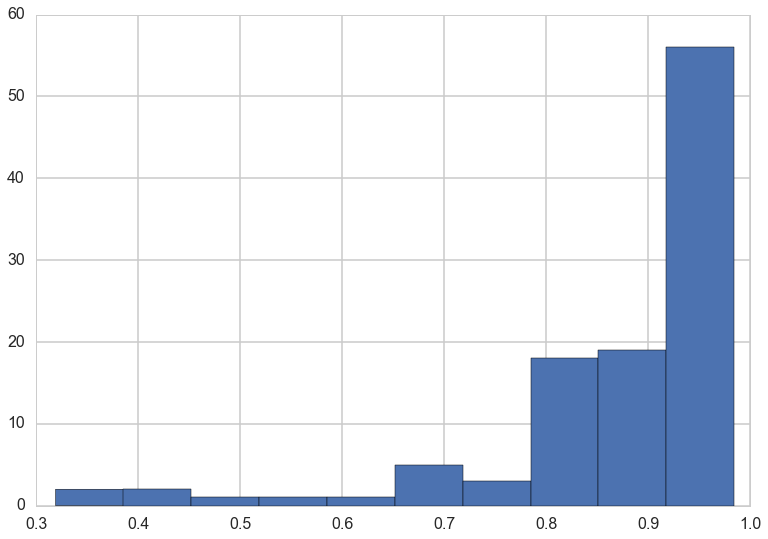

In [31]:
AdRp_NoA_correls = AdRp.corrwith(NoA)
_=plt.hist(AdRp_NoA_correls)


# Add values in dataframes that are correlated by more than 75%

In [48]:
# Take only entries where correlation greater than .75

AdRp_NoA_correls[AdRp_NoA_correls>.75].index
New_NoA= NoA[AdRp_NoA_correls[AdRp_NoA_correls>.75].index]
New_AdRp= AdRp[AdRp_NoA_correls[AdRp_NoA_correls>.75].index]

In [50]:
New_NoA.shape ==New_AdRp.shape

True

Merge NoA and AdRp datasets

In [52]:
Merged = New_NoA.add(New_AdRp)
Merged.head()

,damID-Dam_Fr188_C1,damID-Dam_Fr188_C2,damID-Dam_Fr188_C3,damID-Dam_Fr188_C4,damID-Dam_Fr188_T3,damID-Dam_Fr188_T4,damID-Dam_Zi257_C2,damID-Dam_Zi257_C3,damID-Dam_Zi257_W,damID-Dam_Zi275_T1,damID-Lam_Fr188_C3,damID-Lam_Fr188_C,damID-Lam_Fr188_T2,damID-Lam_Zi257_C1,damID-Lam_Zi257_C2,damID-Lam_Zi257_C3,damID-Lam_Zi257_T1,damID-Lam_Zi257_T2,damID2-D1_Fr188_C2,damID2-D1_Fr188_C3,damID2-D1_Fr188_T3,damID2-D1_Fr89_C3,damID2-D1_Fr89_T3,damID2-D1_Zi238_C1,damID2-D1_Zi238_C2,damID2-D1_Zi238_C3,damID2-D1_Zi238_T2,damID2-D1_Zi238_T3,damID2-D1_Zi257_C1,damID2-D1_Zi257_C2,damID2-D1_Zi257_C3,damID2-D1_Zi257_T1,damID2-D1_Zi257_T2,damID2-Dam_Fr89_C1,damID2-Dam_Fr89_C3,damID2-Dam_Fr89_T1,damID2-Dam_Fr89_T2,damID2-Dam_Fr89_T3,damID2-Dam_Zi238_C1,damID2-Dam_Zi238_C2,damID2-Dam_Zi238_C3,damID2-Lam_Fr89_C1,damID2-Lam_Fr89_C2,damID2-Lam_Zi238_C1,damID2-Lam_Zi238_C2,damID2-Lam_Zi238_C3,damID2-Lam_Zi257_C4,damID3-D1_Fr188_T,damID3-D1_Fr188_w1,damID3-D1_Fr188_w2,damID3-D1_Fr188_w3,damID3-D1_Fr89_w1,damID3-D1_Fr89_w2,damID3-D1_Fr89_w3,damID3-D1_Zi238_T,damID3-D1_Zi238_w1,damID3-D1_Zi238_w2,damID3-D1_Zi238_w3,damID3-D1_Zi257_T,damID3-D1_Zi257_w1,damID3-D1_Zi257_w2,damID3-D1_Zi257_w3,damID3-Dam_Fr188_T2,damID3-Dam_Fr188_w1,damID3-Dam_Fr188_w2,damID3-Dam_Fr188_w3,damID3-Dam_Fr89_w1,damID3-Dam_Fr89_w2,damID3-Dam_Fr89_w3,damID3-Dam_Zi238_T1,damID3-Dam_Zi238_T2,damID3-Dam_Zi238_w1,damID3-Dam_Zi238_w2,damID3-Dam_Zi238_w3,damID3-Dam_Zi257_T1,damID3-Dam_Zi257_T2,damID3-Dam_Zi257_w1,damID3-Dam_Zi257_w2,damID3-Dam_Zi257_w3,damID3-Lam_Fr188_T1,damID3-Lam_Fr188_T4,damID3-Lam_Fr188_w1,damID3-Lam_Fr188_w2,damID3-Lam_Fr188_w3,damID3-Lam_Fr89_T1,damID3-Lam_Fr89_T2,damID3-Lam_Fr89_w1,damID3-Lam_Fr89_w2,damID3-Lam_Fr89_w3,damID3-Lam_Zi238_w1,damID3-Lam_Zi238_w2,damID3-Lam_Zi238_w3,damID3-Lam_Zi257_w1,damID3-Lam_Zi257_w2,damID3-Lam_Zi257_w3
0,3,1,0,0,3,4,2,1,1,1,1,2,3,4,2,0,3,2,0,0,0,1,0,0,0,0,0,2,1,1,0,0,9,0,0,0,0,0,1,0,0,0,1,0,2,2,1,0,1,0,0,1,2,1,1,1,1,1,1,0,1,1,2,1,0,2,1,2,0,0,1,0,0,0,0,0,0,2,0,0,0,2,0,1,0,1,0,2,2,1,0,0,0,1,0
1,3,1,1,0,2,4,1,1,1,0,1,1,3,4,2,0,3,3,0,0,0,0,0,0,0,0,0,0,1,1,0,0,10,1,0,0,0,0,1,0,0,0,1,2,2,2,1,0,1,0,0,1,1,0,0,1,1,1,1,0,0,0,2,1,0,3,1,2,1,0,1,0,0,0,0,0,0,2,0,0,0,2,0,0,0,1,0,1,1,0,2,0,1,0,0
2,3,1,1,0,2,4,1,1,1,0,1,1,3,3,1,0,3,3,0,0,0,0,0,0,0,0,1,0,1,1,0,0,10,1,0,0,0,0,1,1,0,0,1,3,2,2,1,0,1,0,0,2,1,0,0,1,1,1,1,0,0,0,2,1,0,3,1,2,1,0,1,0,0,0,0,0,0,2,0,0,0,2,0,0,0,1,0,1,2,0,2,1,1,0,0
3,1,4,3,0,3,1,1,1,0,0,6,1,4,1,2,1,1,2,0,1,0,0,1,0,0,0,1,0,0,2,0,0,4,1,0,0,0,0,1,3,2,1,0,5,1,2,0,1,3,1,1,2,2,1,0,2,0,1,1,2,0,5,2,0,2,4,1,1,3,0,0,1,0,0,0,0,1,2,0,2,2,1,4,0,1,1,4,9,3,2,4,1,5,0,3
4,0,3,2,2,0,2,2,0,3,1,1,3,4,5,2,2,1,1,0,0,0,0,0,0,2,0,0,0,0,0,1,0,1,1,1,0,0,0,0,1,0,2,2,0,1,2,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,1,0,2,0,2,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,1,2,1,2,0,0,2,0,1,3


# Keep only columns with combined counts greater than 500000

Actually there was nothing to do here because the minimum column counts was 1493859.

In [60]:
min(Merged.sum(axis=0))

1493859

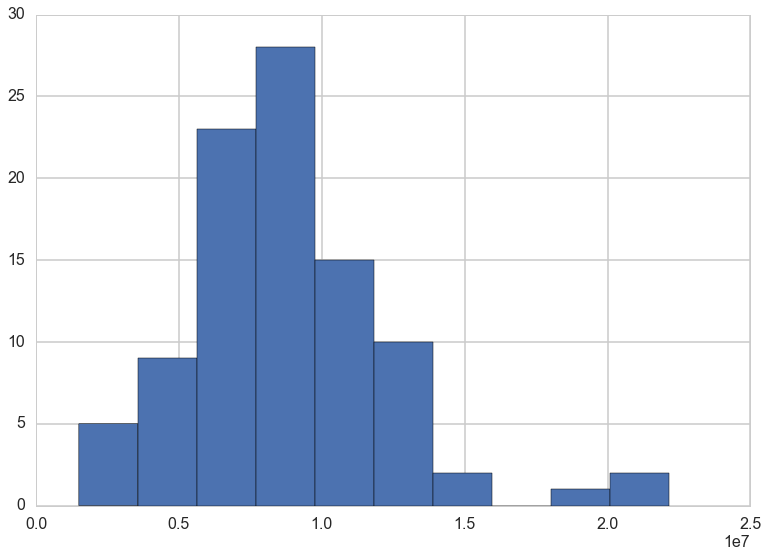

In [71]:
_=plt.hist(Merged.sum(axis=0))

# Making PCAs of each protein/tissue combination

First let's turn column names into a dataframe, so that we can easily separate out tissue, protein, country, line, etc

In [101]:
def split_names(row):
    labels=["RunProtein", "CountryLine", "TissueRep", "dataset", "notSure1", "notSure2"]
    d = {lab:ele for lab,ele in zip(labels, row.split("_"))}
    return d

def split_TissueRep(TissueRep):
    return {label:ele for label, ele in zip(["Tissue", "Rep"], TissueRep)}

def split_CountryLine(CL): 
    return {label:ele for label, ele in zip(["Country", "Line"], [CL[:2], CL[2:]])}

def separate_protein(RunProtein):
    return {label:ele for label, ele in zip(["NotSureProtein", "protein"], RunProtein.split("-"))}

file_names = Merged.columns

ind = [row.split("_cut")[0] for row in file_names]

file_names=pd.DataFrame([split_names(row) for row in file_names])

file_names=pd.concat([file_names, pd.DataFrame([split_TissueRep(row) for row in file_names["TissueRep"]])], axis=1)
del file_names["TissueRep"]

file_names=pd.concat([file_names, pd.DataFrame([split_CountryLine(row) for row in file_names["CountryLine"]])], axis=1)
del file_names["CountryLine"]

file_names=pd.concat([file_names, pd.DataFrame([separate_protein(row) for row in file_names["RunProtein"]])], axis=1)
del file_names["RunProtein"]

file_names.index=ind

file_names.head(n=10)

,Rep,Tissue,Country,Line,NotSureProtein,protein
damID-Dam_Fr188_C1,1,C,Fr,188,damID,Dam
damID-Dam_Fr188_C2,2,C,Fr,188,damID,Dam
damID-Dam_Fr188_C3,3,C,Fr,188,damID,Dam
damID-Dam_Fr188_C4,4,C,Fr,188,damID,Dam
damID-Dam_Fr188_T3,3,T,Fr,188,damID,Dam
damID-Dam_Fr188_T4,4,T,Fr,188,damID,Dam
damID-Dam_Zi257_C2,2,C,Zi,257,damID,Dam
damID-Dam_Zi257_C3,3,C,Zi,257,damID,Dam
damID-Dam_Zi257_W,NaN,W,Zi,257,damID,Dam
damID-Dam_Zi275_T1,1,T,Zi,275,damID,Dam


Next, let's make protein/tissue masks

In [102]:
#Protein masks
DamMask = [file_names.loc[name].protein=="Dam" for name in Merged.columns]
LamMask = [file_names.loc[name].protein=="Lam" for name in Merged.columns]
D1Mask = [file_names.loc[name].protein=="D1" for name in Merged.columns]

#Tissue masks
TMask = [file_names.loc[name].Tissue=="T" for name in Merged.columns]
CMask = [file_names.loc[name].Tissue=="C" for name in Merged.columns]
WMask = [(file_names.loc[name].Tissue=="W" or file_names.loc[name].Tissue=="w") for name in Merged.columns]


In [104]:
DamTMask = [a and b for a, b in zip(DamMask, TMask)]
DamCMask = [a and b for a, b in zip(DamMask, CMask)]
DamWMask = [a and b for a, b in zip(DamMask, WMask)]

LamTMask = [a and b for a, b in zip(LamMask, TMask)]
LamCMask = [a and b for a, b in zip(LamMask, CMask)]
LamWMask = [a and b for a, b in zip(LamMask, WMask)]

D1TMask = [a and b for a, b in zip(D1Mask, TMask)]
D1CMask = [a and b for a, b in zip(D1Mask, CMask)]
D1WMask = [a and b for a, b in zip(D1Mask, WMask)]

Let's normalize the Merged dataset by column counts

In [134]:
MergedNormalized=Merged.div(Merged.sum(axis=0), axis=1)
MergedNormalized.head()

,damID-Dam_Fr188_C1,damID-Dam_Fr188_C2,damID-Dam_Fr188_C3,damID-Dam_Fr188_C4,damID-Dam_Fr188_T3,damID-Dam_Fr188_T4,damID-Dam_Zi257_C2,damID-Dam_Zi257_C3,damID-Dam_Zi257_W,damID-Dam_Zi275_T1,damID-Lam_Fr188_C3,damID-Lam_Fr188_C,damID-Lam_Fr188_T2,damID-Lam_Zi257_C1,damID-Lam_Zi257_C2,damID-Lam_Zi257_C3,damID-Lam_Zi257_T1,damID-Lam_Zi257_T2,damID2-D1_Fr188_C2,damID2-D1_Fr188_C3,damID2-D1_Fr188_T3,damID2-D1_Fr89_C3,damID2-D1_Fr89_T3,damID2-D1_Zi238_C1,damID2-D1_Zi238_C2,damID2-D1_Zi238_C3,damID2-D1_Zi238_T2,damID2-D1_Zi238_T3,damID2-D1_Zi257_C1,damID2-D1_Zi257_C2,damID2-D1_Zi257_C3,damID2-D1_Zi257_T1,damID2-D1_Zi257_T2,damID2-Dam_Fr89_C1,damID2-Dam_Fr89_C3,damID2-Dam_Fr89_T1,damID2-Dam_Fr89_T2,damID2-Dam_Fr89_T3,damID2-Dam_Zi238_C1,damID2-Dam_Zi238_C2,damID2-Dam_Zi238_C3,damID2-Lam_Fr89_C1,damID2-Lam_Fr89_C2,damID2-Lam_Zi238_C1,damID2-Lam_Zi238_C2,damID2-Lam_Zi238_C3,damID2-Lam_Zi257_C4,damID3-D1_Fr188_T,damID3-D1_Fr188_w1,damID3-D1_Fr188_w2,damID3-D1_Fr188_w3,damID3-D1_Fr89_w1,damID3-D1_Fr89_w2,damID3-D1_Fr89_w3,damID3-D1_Zi238_T,damID3-D1_Zi238_w1,damID3-D1_Zi238_w2,damID3-D1_Zi238_w3,damID3-D1_Zi257_T,damID3-D1_Zi257_w1,damID3-D1_Zi257_w2,damID3-D1_Zi257_w3,damID3-Dam_Fr188_T2,damID3-Dam_Fr188_w1,damID3-Dam_Fr188_w2,damID3-Dam_Fr188_w3,damID3-Dam_Fr89_w1,damID3-Dam_Fr89_w2,damID3-Dam_Fr89_w3,damID3-Dam_Zi238_T1,damID3-Dam_Zi238_T2,damID3-Dam_Zi238_w1,damID3-Dam_Zi238_w2,damID3-Dam_Zi238_w3,damID3-Dam_Zi257_T1,damID3-Dam_Zi257_T2,damID3-Dam_Zi257_w1,damID3-Dam_Zi257_w2,damID3-Dam_Zi257_w3,damID3-Lam_Fr188_T1,damID3-Lam_Fr188_T4,damID3-Lam_Fr188_w1,damID3-Lam_Fr188_w2,damID3-Lam_Fr188_w3,damID3-Lam_Fr89_T1,damID3-Lam_Fr89_T2,damID3-Lam_Fr89_w1,damID3-Lam_Fr89_w2,damID3-Lam_Fr89_w3,damID3-Lam_Zi238_w1,damID3-Lam_Zi238_w2,damID3-Lam_Zi238_w3,damID3-Lam_Zi257_w1,damID3-Lam_Zi257_w2,damID3-Lam_Zi257_w3
0,2.385905e-07,1.041207e-07,0.000000e+00,0.000000e+00,2.789894e-07,3.440296e-07,2.871086e-07,1.223180e-07,1.798545e-07,8.969052e-08,1.152570e-07,1.893684e-07,2.603926e-07,1.988705e-07,1.046306e-07,0.000000e+00,3.265098e-07,1.379674e-07,0,0.000000e+00,0,1.106756e-07,0.000000e+00,0,0.000000e+00,0,0.000000e+00,3.736316e-07,2.090204e-07,1.276142e-07,0.000000e+00,0,2.400392e-06,0.000000e+00,0.000000e+00,0,0,0,1.620621e-07,0.000000e+00,0.000000e+00,0.000000e+00,1.602826e-07,0.000000e+00,2.357555e-07,1.563536e-07,4.043193e-07,0.000000e+00,1.053886e-07,0.000000e+00,0.000000e+00,1.026308e-07,1.820642e-07,1.261826e-07,8.314715e-08,1.064299e-07,1.146437e-07,1.418917e-07,1.044418e-07,0.000000e+00,1.364611e-07,1.036173e-07,1.539295e-07,1.045858e-07,0.000000e+00,2.383843e-07,1.137310e-07,2.722941e-07,0.000000e+00,0,7.560954e-08,0.000000e+00,0,0.000000e+00,0.000000e+00,0,0.000000e+00,2.392067e-07,0.000000e+00,0.000000e+00,0.000000e+00,3.432991e-07,0.000000e+00,1.422053e-07,0.000000e+00,7.723005e-08,0.000000e+00,2.162562e-07,1.977559e-07,1.020664e-07,0.000000e+00,0.000000e+00,0.000000e+00,1.364885e-07,0.000000e+00
1,2.385905e-07,1.041207e-07,7.852951e-08,0.000000e+00,1.859929e-07,3.440296e-07,1.435543e-07,1.223180e-07,1.798545e-07,0.000000e+00,1.152570e-07,9.468422e-08,2.603926e-07,1.988705e-07,1.046306e-07,0.000000e+00,3.265098e-07,2.069510e-07,0,0.000000e+00,0,0.000000e+00,0.000000e+00,0,0.000000e+00,0,0.000000e+00,0.000000e+00,2.090204e-07,1.276142e-07,0.000000e+00,0,2.667102e-06,1.319815e-07,0.000000e+00,0,0,0,1.620621e-07,0.000000e+00,0.000000e+00,0.000000e+00,1.602826e-07,2.734766e-07,2.357555e-07,1.563536e-07,4.043193e-07,0.000000e+00,1.053886e-07,0.000000e+00,0.000000e+00,1.026308e-07,9.103212e-08,0.000000e+00,0.000000e+00,1.064299e-07,1.146437e-07,1.418917e-07,1.044418e-07,0.000000e+00,0.000000e+00,0.000000e+00,1.539295e-07,1.045858e-07,0.000000e+00,3.575765e-07,1.137310e-07,2.722941e-07,1.283665e-07,0,7.560954e-08,0.000000e+00,0,0.000000e+00,0.000000e+00,0,0.000000e+00,2.392067e-07,0.000000e+00,0.000000e+00,0.000000e+00,3.432991e-07,0.000000e+00,0.000000e+00,0.000000e+00,7.723005e-08,0.000000e+00,1.081281e-07,9.887795e-08,0.000000e+00,1.979

In [135]:
#here you can choose to input the normalized or not normalized merged dataset

def create_subdfs(Merged):

    LamT=Merged.ix[:,LamTMask]
    DamT=Merged.ix[:,DamTMask]
    D1T=Merged.ix[:,D1TMask]

    LamC=Merged.ix[:,LamCMask]
    DamC=Merged.ix[:,DamCMask]
    D1C=Merged.ix[:,D1CMask]

    LamW=Merged.ix[:,LamWMask]
    DamW=Merged.ix[:,DamWMask]
    D1W=Merged.ix[:,D1WMask]
    
    return LamT, DamT, D1T, LamC, DamC, D1C, LamW, DamW, D1W

LamT, DamT, D1T, LamC, DamC, D1C, LamW, DamW, D1W = create_subdfs(MergedNormalized)

Now we run PCA for each tissue/protein combo.

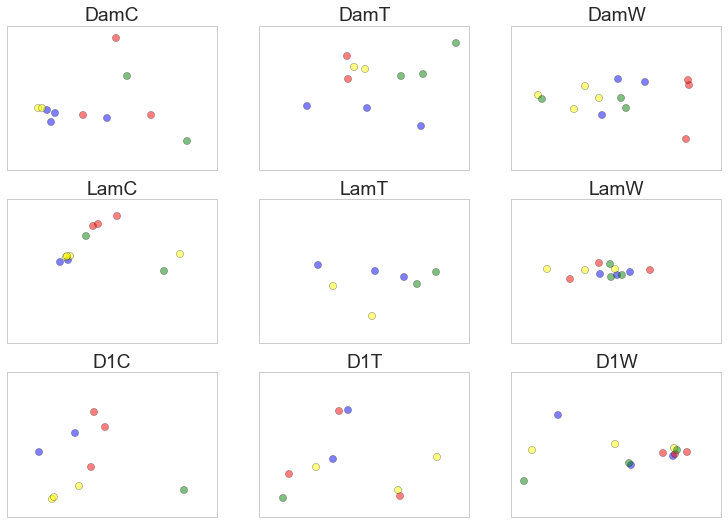

In [186]:
def plot_PCA(data, subplot_spec, title):
    
    pca = PCA(n_components=10)
    X = pca.fit_transform(data.transpose())
    #print pca.explained_variance_ratio_.sum(), "percentage var explained"
    #print pca.explained_variance_ratio_*100, "explained by first PCs"
    
    df=pd.DataFrame()
    for i in range(pca.explained_variance_ratio_.shape[0]):
        df["pc%i" % (i+1)] = X[:,i]

    colors = ["blue", "red", "yellow", 'green']
    labels= ["188","238","257", "89"]
    
    ax1 = fig.add_subplot(subplot_spec, xticklabels=[], yticklabels=[])
    
    for label, color in zip(labels, colors):
        mask = [file_names.loc[name].Line==label for name in data.columns]
        _=ax1.scatter(df[mask]['pc1'], df[mask]['pc2'], c=color, label=label, alpha=.5, s =50)
    ax1.set_title(title)
    ax1.grid(b=False)
    #ax1.axis("off")
    #plt.legend()
    #plt.grid(False)
    #plt.show()

fig = plt.figure()

plot_PCA(DamC, 331, "DamC")
plot_PCA(DamT, 332, "DamT")
plot_PCA(DamW, 333, "DamW")
plot_PCA(LamC, 334, "LamC")
plot_PCA(LamT, 335, "LamT")
plot_PCA(LamW, 336, "LamW")
plot_PCA(D1C, 337, "D1C")
plot_PCA(D1T, 338, "D1T")
plot_PCA(D1W, 339, "D1W")



Blue and green are Fr strains, yellow and red are Zi strains

# Normalizing each data set value by mean(Dam-only) value

The final step would be to take mean(D1) / mean(Dam-only) and mean(Lam) / mean(Dam-only) for each line/tissue combination and look at how those values cluster. This should be a very crude way to account for background noise. Note that you'll need to normalize by counts first before averaging across replicates.

In [160]:
CMean=DamC.mean(axis=1)
TMean=DamT.mean(axis=1)
WMean=DamW.mean(axis=1)

In [203]:
LamCNorm = LamC.div(CMean, axis='index')
LamTNorm = LamT.div(TMean, axis='index')
LamWNorm = LamW.div(WMean, axis='index')

D1CNorm = D1C.div(CMean, axis='index')
D1TNorm = D1T.div(TMean, axis='index')
D1WNorm = D1W.div(WMean, axis='index')

DamCNorm = DamC.div(CMean, axis='index')

Drop any rows where there are inf values

In [204]:
LamCNorm=LamCNorm.replace([np.inf, -np.inf], np.nan).dropna()
LamTNorm=LamTNorm.replace([np.inf, -np.inf], np.nan).dropna()
LamWNorm=LamWNorm.replace([np.inf, -np.inf], np.nan).dropna()

D1CNorm=D1CNorm.replace([np.inf, -np.inf], np.nan).dropna()
D1TNorm=D1TNorm.replace([np.inf, -np.inf], np.nan).dropna()
D1WNorm=D1WNorm.replace([np.inf, -np.inf], np.nan).dropna()

DamCNorm=DamCNorm.replace([np.inf, -np.inf], np.nan).dropna()

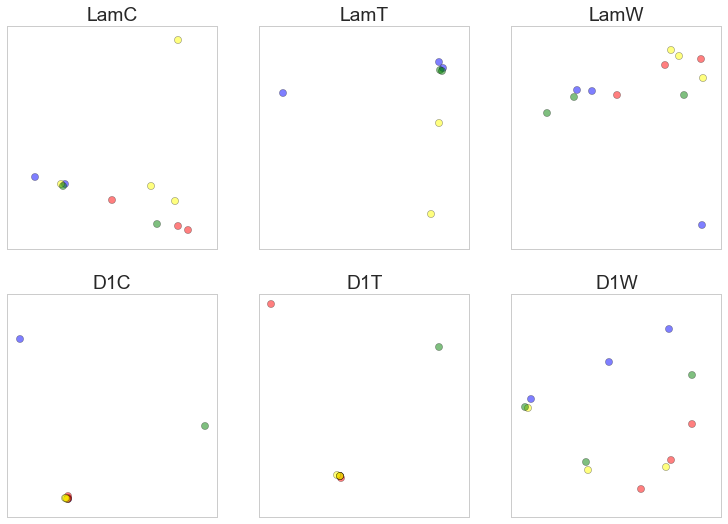

In [206]:
fig = plt.figure()

plot_PCA(LamCNorm, 231, "LamC")
plot_PCA(LamTNorm, 232, "LamT")
plot_PCA(LamWNorm, 233, "LamW")
plot_PCA(D1CNorm, 234, "D1C")
plot_PCA(D1TNorm, 235, "D1T")
plot_PCA(D1WNorm, 236, "D1W")

# Ignore

First we need to get averages for each line/tissue combo in the Dam dataset

In [137]:
DamC.head()

,damID-Dam_Fr188_C1,damID-Dam_Fr188_C2,damID-Dam_Fr188_C3,damID-Dam_Fr188_C4,damID-Dam_Zi257_C2,damID-Dam_Zi257_C3,damID2-Dam_Fr89_C1,damID2-Dam_Fr89_C3,damID2-Dam_Zi238_C1,damID2-Dam_Zi238_C2,damID2-Dam_Zi238_C3
0,2.385905e-07,1.041207e-07,0.000000e+00,0.000000e+00,2.871086e-07,1.223180e-07,0.000000e+00,0.000000e+00,1.620621e-07,0.000000e+00,0.000000e+00
1,2.385905e-07,1.041207e-07,7.852951e-08,0.000000e+00,1.435543e-07,1.223180e-07,1.319815e-07,0.000000e+00,1.620621e-07,0.000000e+00,0.000000e+00
2,2.385905e-07,1.041207e-07,7.852951e-08,0.000000e+00,1.435543e-07,1.223180e-07,1.319815e-07,0.000000e+00,1.620621e-07,2.419919e-07,0.000000e+00
3,7.953015e-08,4.164827e-07,2.355885e-07,0.000000e+00,1.435543e-07,1.223180e-07,1.319815e-07,0.000000e+00,1.620621e-07,7.259757e-07,5.688691e-07
4,0.000000e+00,3.123620e-07,1.570590e-07,2.696517e-07,2.871086e-07,0.000000e+00,1.319815e-07,1.059038e-07,0.000000e+00,2.419919e-07,0.000000e+00


In [141]:
Mask188C = [file_names.loc[name].Line=="188" for name in DamC.columns]
Mask238C = [file_names.loc[name].Line=="238" for name in DamC.columns]
Mask257C = [file_names.loc[name].Line=="257" for name in DamC.columns]
Mask89C = [file_names.loc[name].Line=="89" for name in DamC.columns]

Mask188T = [file_names.loc[name].Line=="188" for name in DamT.columns]
Mask238T = [file_names.loc[name].Line=="238" for name in DamT.columns]
Mask257T = [file_names.loc[name].Line=="257" for name in DamT.columns]
Mask89T = [file_names.loc[name].Line=="89" for name in DamT.columns]

Mask188W = [file_names.loc[name].Line=="188" for name in DamW.columns]
Mask238W = [file_names.loc[name].Line=="238" for name in DamW.columns]
Mask257W = [file_names.loc[name].Line=="257" for name in DamW.columns]
Mask89W = [file_names.loc[name].Line=="89" for name in DamW.columns]

In [147]:
C188=DamC.iloc[:,Mask188C].mean(axis=1)
C89=DamC.iloc[:,Mask89C].mean(axis=1)
C238=DamC.iloc[:,Mask238C].mean(axis=1)
C257=DamC.iloc[:,Mask257C].mean(axis=1)

T188=DamT.iloc[:,Mask188T].mean(axis=1)
T89=DamT.iloc[:,Mask89T].mean(axis=1)
T238=DamT.iloc[:,Mask238T].mean(axis=1)
T257=DamT.iloc[:,Mask257T].mean(axis=1)

T188=DamW.iloc[:,Mask188W].mean(axis=1)
T89=DamW.iloc[:,Mask89W].mean(axis=1)
T238=DamW.iloc[:,Mask238W].mean(axis=1)
T257=DamW.iloc[:,Mask257W].mean(axis=1)

In [151]:
sum(T257==0)

883

In [152]:
LamCNorm = LamC.div(C188, axis='index')